In [74]:
!pip install transformers

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from keras.models import Model
import sklearn
import sys
print(sklearn.__version__)
print(sys.version)
from sklearn.pipeline import Pipeline, FeatureUnion
from transformers.models.bert.modeling_bert import BertModel,BertForMaskedLM

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings("ignore")

1.0.2
3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [76]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [77]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import zipfile

In [79]:
z= zipfile.ZipFile("/content/drive/MyDrive/Colab Notebooks/YouTube-Spam-Collection-v1.zip")
Psy=pd.read_csv(z.open("Youtube01-Psy.csv"))
Katy =pd.read_csv(z.open("Youtube02-KatyPerry.csv"))
LMFAQ =pd.read_csv(z.open("Youtube03-LMFAO.csv"))
Eminem =pd.read_csv(z.open("Youtube04-Eminem.csv"))
Shakira =pd.read_csv(z.open("Youtube05-Shakira.csv"))
frames = [Psy,LMFAQ,Eminem,Shakira,Katy]
result = pd.concat(frames)
result.head(10)

,COMMENT_ID,AUTHOR,DATE,CONTENT,CLASS
0,LZQPQhLyRh80UYxNuaDWhIGQYNQ96IuCg-AYWqNPjpU,Julius NM,2013-11-07T06:20:48,"Huh, anyway check out this you[tube] channel: ...",1
1,LZQPQhLyRh_C2cTtd9MvFRJedxydaVW-2sNg5Diuo4A,adam riyati,2013-11-07T12:37:15,Hey guys check out my new channel and our firs...,1
2,LZQPQhLyRh9MSZYnf8djyk0gEF9BHDPYrrK-qCczIY8,Evgeny Murashkin,2013-11-08T17:34:21,just for test I have to say murdev.com,1
3,z13jhp0bxqncu512g22wvzkasxmvvzjaz04,ElNino Melendez,2013-11-09T08:28:43,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,z13fwbwp1oujthgqj04chlngpvzmtt3r3dw,GsMega,2013-11-10T16:05:38,watch?v=vtaRGgvGtWQ Check this out .﻿,1
5,LZQPQhLyRh9-wNRtlZDM90f1k0BrdVdJyN_YsaSwfxc,Jason Haddad,2013-11-26T02:55:11,"Hey, check out my new website!! This site is a...",1
6,z13lfzdo5vmdi1cm123te5uz2mqig1brz04,ferleck ferles,2013-11-27T21:39:24,Subscribe to my channel ﻿,1
7,z122wfnzgt30fhubn04cdn3xfx2mxzngsl40k,Bob Kanowski,2013-11-28T12:33:27,i turned it on mute as soon is i came on i jus...,0
8,z13ttt1jcraqexk2o234ghbgzxymz1zzi04,Cony,2013-11-28T16:01:47,You should check my channel for Funny VIDEOS!!﻿,1
9,z12avveb4xqiirsix04chxviiljryduwxg0,BeBe Burkey,2013-11-28T16:30:13,and u should.d check my channel and tell me wh...,1


In [80]:
result.shape

(1956, 5)

In [81]:

result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1956 entries, 0 to 349
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   COMMENT_ID  1956 non-null   object
 1   AUTHOR      1956 non-null   object
 2   DATE        1711 non-null   object
 3   CONTENT     1956 non-null   object
 4   CLASS       1956 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 91.7+ KB


In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

#Data preparation
#Remove unnecessary variables:

In [84]:

result.drop(['COMMENT_ID', 'AUTHOR', 'DATE'], axis=1, inplace=True)


In [85]:

result.head()



,CONTENT,CLASS
0,"Huh, anyway check out this you[tube] channel: ...",1
1,Hey guys check out my new channel and our firs...,1
2,just for test I have to say murdev.com,1
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1


In [86]:

result['CONTENT'][2]


2               just for test I have to say murdev.com
2    Hey guys, I&#39;m a human.<br /><br /><br />Bu...
2    my sister just received over 6,500 new <a rel=...
2                                        I love song ﻿
2    Hey guys! Please join me in my fight to help a...
Name: CONTENT, dtype: object

In [87]:

result.isna().sum()



CONTENT    0
CLASS      0
dtype: int64

#value count

In [88]:
result['CLASS'].value_counts()

1    1005
0     951
Name: CLASS, dtype: int64

#Number of ham and spam messages

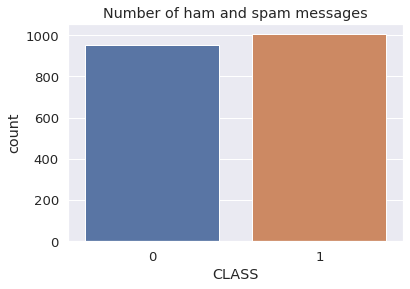

In [89]:
sns.set(style = "darkgrid" , font_scale = 1.2)
sns.countplot(result.CLASS).set_title("Number of ham and spam messages")
plt.show()

In [90]:
result.describe()

,CLASS
count,1956.000000
mean,0.513804
std,0.499937
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


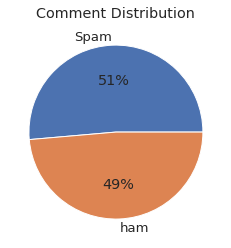

In [91]:
sms = pd.value_counts(result["CLASS"], sort=True)
sms.plot(kind="pie", labels=["Spam", "ham"], autopct="%1.0f%%")

plt.title("Comment Distribution")
plt.ylabel("")
plt.show()

#row length

In [92]:
result['length'] = result.CONTENT.apply(len)
result.head()

,CONTENT,CLASS,length
0,"Huh, anyway check out this you[tube] channel: ...",1,56
1,Hey guys check out my new channel and our firs...,1,166
2,just for test I have to say murdev.com,1,38
3,me shaking my sexy ass on my channel enjoy ^_^ ﻿,1,48
4,watch?v=vtaRGgvGtWQ Check this out .﻿,1,39


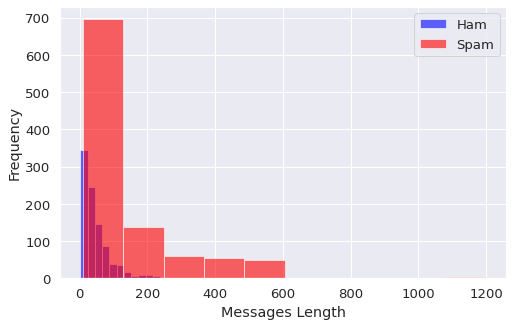

In [93]:
plt.figure(figsize=(8, 5))
result[result.CLASS == 0].length.plot(bins=35, kind='hist', color='blue', label='Ham', alpha=0.6)
result[result.CLASS == 1].length.plot(kind='hist', color='red', label='Spam', alpha=0.6)
plt.legend()
plt.xlabel("Messages Length");

#Now let's see if the length has an influence on messages spam or ham:

In [94]:
"""_, ax = plt.subplots(figsize=(20,5))
sns.kdeplot(result.loc[result.CLASS == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)
sns.kdeplot(result.loc[result.CLASS == 1, "length"], shade=True, label="Spam")
ax.set(
    xlabel="Length",
    ylabel="Density",
    title="Length of messages.",
)
ax.legend(loc="upper right")
plt.show()"""

'_, ax = plt.subplots(figsize=(20,5))\nsns.kdeplot(result.loc[result.CLASS == 0, "length"], shade=True, label="Ham", clip=(-50, 250),)\nsns.kdeplot(result.loc[result.CLASS == 1, "length"], shade=True, label="Spam")\nax.set(\n    xlabel="Length",\n    ylabel="Density",\n    title="Length of messages.",\n)\nax.legend(loc="upper right")\nplt.show()'

#Text Pre-processing
In the next step we clean text, remove stop words and apply stemming operation for each line of text:

#Examples of stop words in English are “a”, “the”, “is”, “are” , in and etc

In [95]:
stop_words = stopwords.words('english')
print(stop_words[::10])

porter = PorterStemmer()

['i', "you've", 'himself', 'they', 'that', 'been', 'a', 'while', 'through', 'in', 'here', 'few', 'own', 'just', 're', 'doesn', 'ma', "shouldn't"]


In [96]:
def clean_text(words):
    """The function to clean text"""
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()                   
    return " ".join(text)

def remove_stopwords(text):
    """The function to removing stopwords"""
    text = [word.lower() for word in text.split() if word.lower() not in stop_words]
    return " ".join(text)

def stemmer(stem_text):
    """The function to apply stemming. It just removes suffixes from the words.
    The stemmed word might not be part of the dictionary, i.e it will not necessarily give meaning.
     There are two main types of stemmer- Porter Stemmer and Snow Ball Stemmer(advanced version of Porter Stemmer)."""
    stem_text = [porter.stem(word) for word in stem_text.split()]
    return " ".join(stem_text)

In [97]:
result['CONTENT'] = result['CONTENT'].apply(clean_text)
result['CONTENT'] =result['CONTENT'].apply(remove_stopwords)
result['CONTENT'] =result['CONTENT'].apply(stemmer)

In [98]:
result.head()

,CONTENT,CLASS,length
0,huh anyway check tube channel kobyoshi,1,56
1,hey guy check new channel first vid us monkey ...,1,166
2,test say murdev com,1,38
3,shake sexi ass channel enjoy,1,48
4,watch v vtarggvgtwq check,1,39


In [99]:
print(result['CONTENT'].apply(lambda x: len(x.split(' '))).sum())

18900


In [100]:
import transformers
from transformers import BertTokenizer, TFBertModel

#To do the tokenization of our datasets we have to choose a pre-trained model. We load the basic model (bert-large-uncased) from the Huggingface Transformers library.




In [101]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')
tokenizer

PreTrainedTokenizer(name_or_path='bert-large-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})

#Now we have to load BERT model. In the Transformers library is avaliable many different BERT models. We use the „TFBertModel” model (bert-base-uncased) from the library.

In [102]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [103]:
X = result['CONTENT']
y = result['CLASS']

In [104]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

#The function which allows to encode our dataset with BERT tokenizer. We have decided on a maximum sentence length is 64 (maxlen)

In [105]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

#Based on this encodings for our training and testing datasets are generated as follows:

In [106]:
X_train_input_ids, X_train_attention_masks = encode(X_train.values, maxlen=64)
X_test_input_ids, X_test_attention_masks = encode(X_test.values, maxlen=64)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [107]:
print(X_test_input_ids, X_test_attention_masks )

[[ 101 3422  102 ...    0    0    0]
 [ 101 2112 2072 ...    0    0    0]
 [ 101 3124 4638 ...    0    0    0]
 ...
 [ 101 2190 9680 ...    0    0    0]
 [ 101 4638 2678 ...    0    0    0]
 [ 101 2066 2299 ...    0    0    0]] [[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]


#Build the model
We create a model using BERT model and then add two Dense layers with Dropout layer

In [108]:
def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(64,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(64,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [109]:
model = build_model(bert_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 tf_bert_model_1 (TFBertModel)  TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 64,                                          

#We set class weights for the loss function to adjust for class imbalance. 'Spam' variable is set to weight 5x more.

We train the model for 10 epoch:

In [110]:
class_weight = {0: 1, 1: 5}

In [111]:
Metrics = [tf.keras.metrics.BinaryAccuracy(name = 'accuracy'),
           tf.keras.metrics.Precision(name = 'precision'),
           tf.keras.metrics.Recall(name = 'recall')
           ]

In [112]:
# compiling our model
model.compile(optimizer ='adam',
               loss = 'binary_crossentropy',
               metrics = Metrics)

In [113]:

history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test),
    class_weight=class_weight)

Epoch 1/10
49/49 [==============================] - 49s 476ms/step - loss: 1.7846 - accuracy: 0.5185 - precision: 0.5179 - recall: 0.9678 - val_loss: 1.0724 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 1.0000
Epoch 2/10
49/49 [==============================] - 20s 419ms/step - loss: 1.4093 - accuracy: 0.5160 - precision: 0.5160 - recall: 1.0000 - val_loss: 1.0879 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 1.0000
Epoch 3/10
49/49 [==============================] - 21s 426ms/step - loss: 1.4032 - accuracy: 0.5160 - precision: 0.5160 - recall: 1.0000 - val_loss: 0.9932 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 1.0000
Epoch 4/10
49/49 [==============================] - 21s 425ms/step - loss: 1.3871 - accuracy: 0.5160 - precision: 0.5160 - recall: 1.0000 - val_loss: 0.8792 - val_accuracy: 0.5051 - val_precision: 0.5051 - val_recall: 1.0000
Epoch 5/10
49/49 [==============================] - 21s 428ms/step - loss: 1.3897 - accuracy: 0.5160

#Visualization of training:

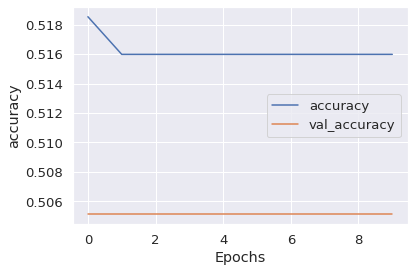

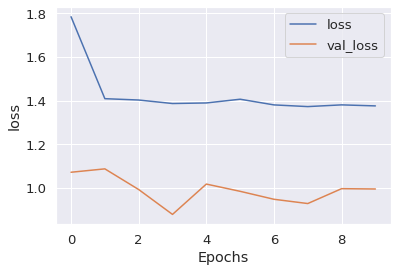

In [116]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [115]:
#save model
model.save_weights('bert_model')